In [271]:
import matplotlib.pyplot as plt
import random
import numpy as np

import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors
from matplotlib import ticker, cm
import pickle

from scipy.stats import gamma as Gamma
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import expon

import seaborn as sns

from scipy.special import kolmogorov, erf
from scipy.special import gamma, factorial
from scipy.optimize import minimize, Bounds


# Case 1 

% Case 1: fully synthetic case
Mdata = 1e3;
mu = 2; sigma = 1;
tau1 = exprnd(lognrnd(mu,sigma,1,Mdata));
figure(1), histogram(tau1,40,'binlimits',[0 100]);
title('Case 1: fully synthetic case');

% Q1: tau1 is now exactly ~Exp(logN(mu,sigma)). Given data tau1, can
% we find a good estimate lambda1 ~ logN(mu,sigma)?
%
% Partial answer:
% https://en.wikipedia.org/wiki/Exponential_distribution#Bayesian_inference

In [175]:
Mdata = 2000
mu = 2
sigma = 1
tau1 = np.zeros((1, Mdata))

lamda = lognorm(sigma,scale = np.exp(mu)).rvs(size=(1,Mdata))

for i in range(Mdata):
    tau1[0,i] = expon(scale=lamda[0,i]).rvs(size=1)

(0.0, 100.0)

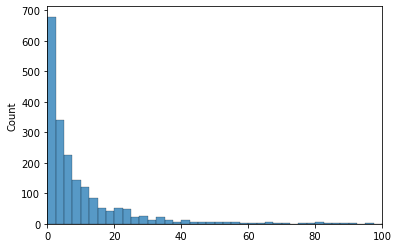

In [176]:
sns.histplot(tau1[0],  binwidth=2.5)
plt.xlim(0,100)

In [177]:
print("mean: ", np.mean(tau1))
print("std: ", np.std(tau1))

mean:  11.847401690126185
std:  23.956402853723795


Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

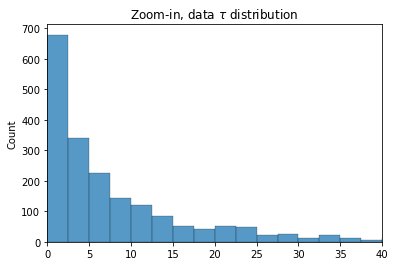

In [178]:
sns.histplot(tau1[0],  binwidth=2.5)
plt.xlim(0,40)
plt.title(r"Zoom-in, data $\tau$ distribution")

Text(0.5, 1.0, 'Parameters $\\lambda$ distribution')

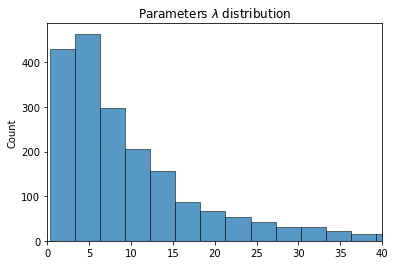

In [179]:
sns.histplot(lamda[0],  binwidth=3)
plt.xlim(0,40)
plt.title(r"Parameters $\lambda$ distribution")

In [180]:
print("mean: ", np.mean(lamda))
print("std: ", np.std(lamda))

mean:  11.993256282097166
std:  15.117062966343187


In [187]:
def Gamma_density(x, params):
    alpha, beta = params
    p = beta**alpha/gamma(alpha)*(x**(alpha-1))*np.exp(-x*beta)
    return p

In [188]:
def LogLikelihood(params, data=[], func=Gamma_density):  
    l = np.sum(np.log(func(data, params)))
    #print(l, params)
    return l

In [189]:
def Maximize_LogLikelihood(params, data=[], func=Gamma_density):
    return -LogLikelihood(params, data, func)

In [190]:
x0 = np.array([1.1, 1])
bnds = ((1.00001, 100), (0.0001, 100))
Estimates = minimize(Maximize_LogLikelihood, x0, args=(tau1,Gamma_density),method='TNC', bounds=bnds, tol=1e-10)

In [191]:
alpha, beta = Estimates.x
mean_post = alpha/beta
 
print("alpha : ", alpha)
print("beta : ", beta)
print("Mean posterior : ", mean_post)

alpha :  1.0000100000000032
beta :  0.08440753246116373
Mean posterior :  11.847402368504401


(0.0, 20.0)

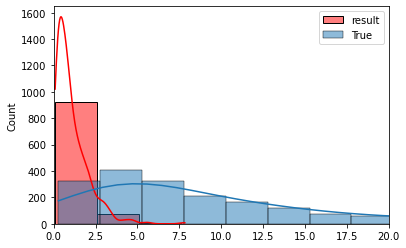

In [194]:
rv = Gamma(alpha, beta)
r = rv.rvs(size=1000)

sns.histplot(r,  binwidth=2.5, color = "r", label = "result", kde=True)
sns.histplot(lamda[0],  binwidth=2.5, label = "True ", kde=True)


plt.legend()
plt.xlim(0,20)

% Case 2: synthetic case, internal states
M = 5; % internal states
lambda = linspace(0,1,M+2); lambda([1 end]) = [];
tau2 = sum(exprnd(repmat(lambda,Mdata,1)),2)';
figure(2), histogram(tau2,40,'binlimits',[0 10]);
title('Case 2: synthetic case, internal states');

% Q2: from data tau2 above, can we find estimates of lamda(i), i =
% 1...M above? Maximum-Likelhood estimates? Bayesian estimates?
%
% The likelihood for a sum of exponentially distributed waiting time
% has been discussed here: "Sum of independent exponentials": Problem
% 12 of Chapter I in Feller: An Introduction to Probability Theory and
% its Applications, Volume II. See
% https://people.maths.bris.ac.uk/~mb13434/sumexp.pdf
%
% On a related note: Gong, Y., Mao, Y.-H., Zhang, C., 2012. "Hitting
% time distributions for denumerable birth and death processes" in
% J. Theor. Probab. 25 (4),
% 950--980. https://doi.org/10.1007/s10959-012-0436-1.

# Case 2 

In [197]:
def Density_SumOIndependentExp(x, lambdas):
    lambdas=1/lambdas #Why I have it?
    product_lambdas = np.prod(lambdas)
    n = len(lambdas)
    s = 0
    for j in range(n):
        denominator = 1
        for k in range(n):
            if (k!= j):
                denominator*=(lambdas[k]-lambdas[j])
        s+=((np.exp(-lambdas[j]*x))/denominator)

    return product_lambdas*s
    

In [198]:
def generate_tau(lambdas, Mdata=1000):
    M = len(lambdas)
    tau2 = np.zeros((1, Mdata))
    generated_exps = np.zeros((M, Mdata))
    i=0
    for exp in lambdas:
        generated_exps[i, :] = expon(scale=lambdas[i]).rvs(size=Mdata)
        i+=1

    tau2 = np.sum(generated_exps, axis = 0)   
    
    return tau2, generated_exps
            

## M = 1

It is for checking, because I still have problems in function 

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

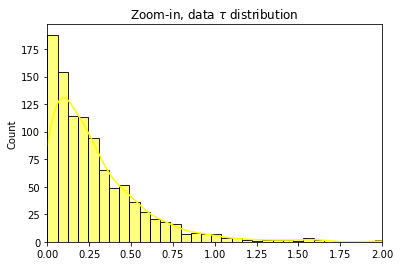

In [204]:
Mdata = 1000
M = 1 # internal states
lamda2 = np.array([0.3 ])
tau2, generated_exps = generate_tau(lamda2, Mdata)

sns.histplot(generated_exps[0, :], color = "yellow", kde=True)
 
 
plt.xlim(0,2)
plt.title(r"Zoom-in, data $\tau$ distribution")

(0.0, 2.0)

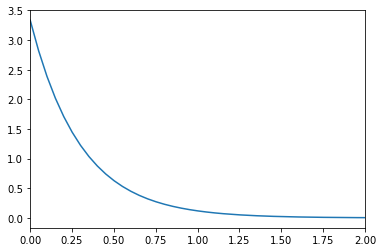

In [205]:
x = np.linspace(0,20,400)
plt.plot(x, Density_SumOIndependentExp(x, lamda2))
plt.xlim(0,2)

In [206]:
x0 = np.array([1])
bnds = np.ones((M,2))*4.1
bnds[:,0]*=1e-2
Estimates = minimize(Maximize_LogLikelihood, x0, args=(tau2,Density_SumOIndependentExp),
                     method='TNC', bounds=bnds, tol=1e-10)

In [207]:
Estimates

     fun: -253.67074188116533
     jac: array([0.])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 28
     nit: 4
  status: 1
 success: True
       x: array([0.28545503])

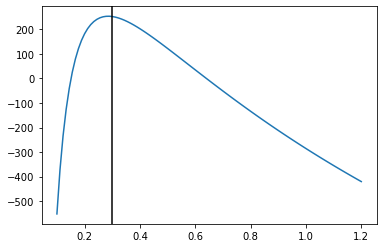

In [208]:
x = np.linspace(0.1,1.2,100)
y = np.linspace(0.1,1.2,100)
for i in range(len(x)):
    y[i] =LogLikelihood(np.array([x[i]]), data=tau2, func=Density_SumOIndependentExp)
    
plt.plot(x, y)
plt.axvline(0.3, c= "k")

## M = 2 
2 internal states for visualization 

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

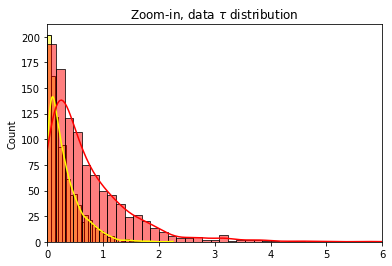

In [226]:
Mdata = 1000
M = 2 # internal states
lamda2 = np.array([0.3,0.7])
tau2, generated_exps = generate_tau(lamda2, Mdata)

sns.histplot(generated_exps[0, :], color = "yellow", kde=True)
sns.histplot(generated_exps[1, :], color = "r", kde=True)
 
plt.xlim(0,6)
plt.title(r"Zoom-in, data $\tau$ distribution")

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

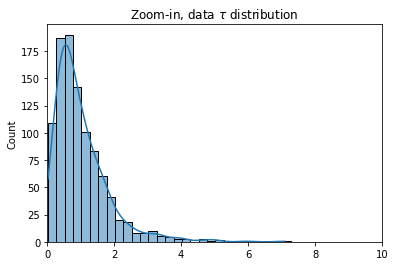

In [227]:
sns.histplot(tau2, binwidth=0.25, kde=True)
plt.xlim(0,10)
plt.title(r"Zoom-in, data $\tau$ distribution")

(0.0, 10.0)

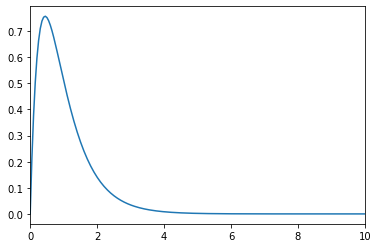

In [228]:
#sns.histplot(Density_SumOIndependentExp(tau2, lamda2), kde=True)

x = np.linspace(0,20,400)
plt.plot(x, Density_SumOIndependentExp(x, 
                                       lamda2))
plt.xlim(0,10)

In [229]:
L = np.arange(0.2, 0.95, 0.025)
xy_grid, yx_grid = np.meshgrid(L, L)

n=len(L)
Likelyhoods = np.zeros((n,n))
for i in range(len(xy_grid)):
    for j in range(len(xy_grid)):
        Likelyhoods[i,j] = Likelyhoods[j,i] = LogLikelihood(
            np.array([xy_grid[i,j], yx_grid[i,j]]),
            data=tau2, func=Density_SumOIndependentExp)
    

<ipython-input-197-3094f19be29a>:11: RuntimeWarning: divide by zero encountered in true_divide
  s+=((np.exp(-lambdas[j]*x))/denominator)


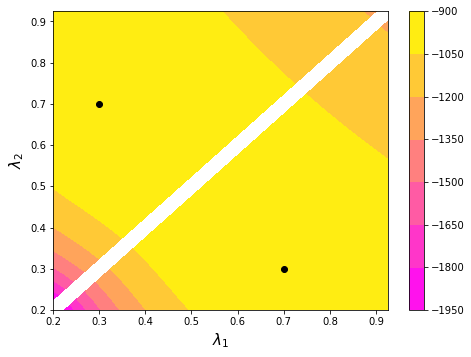

In [231]:
plt.figure(figsize=(7.5,5.5))
#plt.contourf( Likelyhoods,  extend='both')
plt.xlabel(r"$\lambda_1$", fontsize=15)
plt.ylabel(r"$\lambda_2$", fontsize=15)
plt.contourf(xy_grid, yx_grid , Likelyhoods, cmap = 'spring' )
plt.colorbar()
plt.scatter(lamda2,lamda2[::-1], c= "k")

In [232]:
x0 = np.arange(1, M+1)/10
 
bnds = np.ones((M,2))*1.1
bnds[:,0]*=1e-2
Estimates = minimize(Maximize_LogLikelihood, x0, args=(tau2,Density_SumOIndependentExp),
                     method='TNC', bounds=bnds, tol=1e-10)
print("%.3f "*len(Estimates.x) % tuple(Estimates.x) ) 

0.280 0.732 


True values: [0.3,0.7]

Not very bad estimation! 

In [233]:
generatedFromEstimatedParams, generated_expsParams = generate_tau(Estimates.x, Mdata)
#generatedFromEstimatedParams, generated_expsParams = generate_tau([2,3/2], Mdata)

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

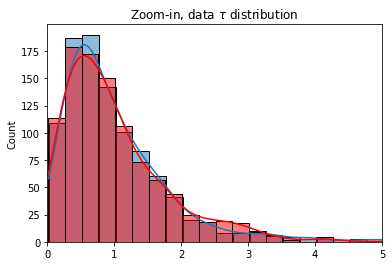

In [234]:
sns.histplot(tau2, binwidth=0.25, kde=True)
sns.histplot(generatedFromEstimatedParams, binwidth=0.25, kde=True, color= "red")
plt.xlim(0,5)
plt.title(r"Zoom-in, data $\tau$ distribution")

In [235]:
print("True moments : ")
print(np.mean(tau2), np.std(tau2))

print("Generated after optimizing moments : ")
print(np.mean(generatedFromEstimatedParams), np.std(generatedFromEstimatedParams))

True moments : 
1.0114568468436582 0.8147265099610825
Generated after optimizing moments : 
1.0190673629888019 0.8175500041889471


## M = 5 

In [276]:
Mdata = 10000
M = 5 # internal states
lamda2 = np.arange(1,6,1)/6
tau2, generated_exps = generate_tau(lamda2, Mdata)

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

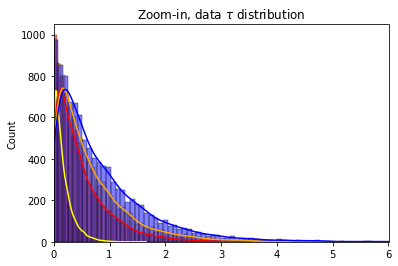

In [277]:
sns.histplot(generated_exps[0, :], color = "yellow", kde=True)
sns.histplot(generated_exps[2, :], color = "r", kde=True)
sns.histplot(generated_exps[3, :], color = "orange", kde=True)
sns.histplot(generated_exps[4, :], color = "b", kde=True)
plt.xlim(0,6)
plt.title(r"Zoom-in, data $\tau$ distribution")

Text(0.5, 1.0, 'Zoom-in, data $\\tau$ distribution')

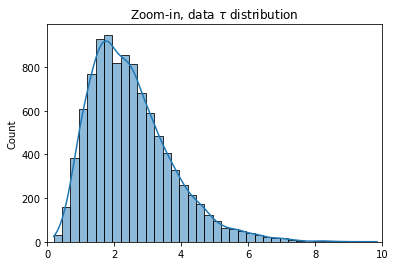

In [278]:
sns.histplot(tau2, binwidth=0.25, kde=True)
plt.xlim(0,10)
plt.title(r"Zoom-in, data $\tau$ distribution")

(0.0, 10.0)

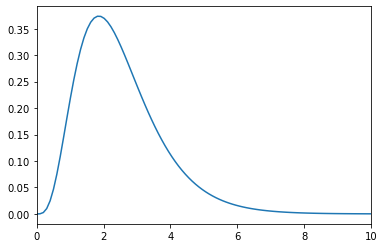

In [279]:
x = np.linspace(0,10,100)
plt.plot(x,Density_SumOIndependentExp(x, lamda2) )
plt.xlim(0,10)

In [280]:
x0 = np.arange(1, M+1)/10
 
#bnds = np.ones((M,2))*1.1
#bnds[:,0]*=1e-3
Estimates = minimize(Maximize_LogLikelihood, x0, args=(tau2,Density_SumOIndependentExp),
                     method='TNC', bounds=bnds, tol=1e-10)

res=sorted(Estimates.x)
print("%.3f "*len(res) % tuple(res) ) 

0.138 0.368 0.520 0.691 0.772 


In [281]:
lamda2

array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333])

Sometimes ML works, sometimes no 